# Feature selection

En este notebook se utilizará la técnica de random forest para seleccionar las variables que acompañaran a la radiación solar en el modelo LSTM.

## Encontrar la mejor combinación de variables de entrada

Se importan las librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf

Se importan los datos

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')
df = df.between_time('08:00:00','17:00:00')
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','RHMAX1H','RHMIN1H','PRSUM1H','PAAVG1H','PAMAX1H','PAMIN1H','WS1HA','WS1HX','WD1HA']]
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')
df_test = df_test.between_time('08:00:00','17:00:00')
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','RHMAX1H','RHMIN1H','PRSUM1H','PAAVG1H','PAMAX1H','PAMIN1H','WS1HA','WS1HX','WD1HA']]

Se quita la radiación solar de los datos de entrada

In [ ]:
x_train = df.drop(columns=['SRGLOAVG1H'])

In [ ]:
x_train.head()

,TAMAX1H,TAMIN1H,RHMAX1H,RHMIN1H,PRSUM1H,PAAVG1H,PAMAX1H,PAMIN1H,WS1HA,WS1HX,WD1HA
Local_Time,,,,,,,,,,,
2015-01-01 08:00:00,12.2,9.5,96.0,89.0,0.0,743.5,743.7,743.1,2.5,4.6,42
2015-01-01 09:00:00,15.1,12.2,89.0,76.0,0.0,743.8,743.9,743.7,3.3,5.8,59
2015-01-01 10:00:00,18.1,15.1,79.0,57.0,0.0,743.7,743.9,743.4,4.4,8.4,40
2015-01-01 11:00:00,18.4,16.7,66.0,58.0,0.0,743.2,743.4,742.8,4.0,8.1,35
2015-01-01 12:00:00,18.5,17.2,65.0,55.0,0.0,742.6,742.9,742.3,3.5,7.6,34


Se utiliza la radiación solar como salida

In [ ]:
y_train = df['SRGLOAVG1H'].values

In [ ]:
y_train

array([107., 394., 728., ..., 331., 334., 132.])

## Random Forest

Se importan las librerías para Random Forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

Se crea un objeto de Random Forest para regresión

In [ ]:
rf = RandomForestRegressor()

Se establecen los parámetros para una pequeña búsqueda de optimización

In [ ]:
# Number of trees in random forest
n_estimators = [100,200,300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,50,70,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
random_grid

{'bootstrap': [True, False],
 'max_depth': [20, 50, 70, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300]}

Se optimizan los hiperparámetros para el random forest

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 50, 70, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

Se obtiene el mejor modelo de random forest

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
best_random

RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200)

Se obtiene el nombre de las variables

In [ ]:
features = x_train.columns

Se grafica la importancia que le da el modelo de Random Forest a las variables. La importancia se basa en el error cuadrado medio, las barras representan qué tanto crece el error cuando la variable no es considerada.

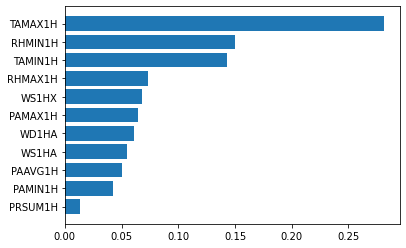

In [ ]:
f_i = list(zip(features,best_random.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

Se utilizarán las cuatro variables más importantes para el modelo LSTM multivariado. Las variables expresan temperatura máxima y mínima, y humedad máxima y mínima.